In [1]:
import math
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle as pkl

device = torch.device("mps")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(100, 256 * 7 * 7)
        self.bc1 = nn.BatchNorm1d(256 * 7 * 7)
        self.lc1 = nn.LeakyReLU(0.2)
        self.uf1 = nn.Unflatten(1, (256, 7, 7))
        self.convt1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.bc2 = nn.BatchNorm2d(128)
        self.lc2 = nn.LeakyReLU(0.2)
        self.convt2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.bc3 = nn.BatchNorm2d(64)
        self.lc3 = nn.LeakyReLU(0.2)
        self.convt3 = nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1)
        self.out = nn.Tanh()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bc1(x)
        x = self.lc1(x)
        x = self.uf1(x)
        x = self.convt1(x)
        x = self.bc2(x)
        x = self.lc2(x)
        x = self.convt2(x)
        x = self.bc3(x)
        x = self.lc3(x)
        x = self.convt3(x)
        x = self.out(x)
        return x

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(0.3),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(0.3),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
        )

    def forward(self, x):
        return self.model(x)

# Loss functions
def real_loss(predicted_outputs, loss_fn, device):
    targets = torch.full((predicted_outputs.size(0),), 0.9, device=device)
    return loss_fn(predicted_outputs.squeeze(), targets)

def fake_loss(predicted_outputs, loss_fn, device):
    targets = torch.zeros(predicted_outputs.size(0)).to(device)
    return loss_fn(predicted_outputs.squeeze(), targets)

# Training function
def train_cycle(gen, disc, gen_optim, disc_optim, loss_fn, train_loader, n_epochs):
    noise_dim = 100
    fixed_z = torch.from_numpy(np.random.uniform(-1, 1, size=(16, noise_dim))).float().to(device)
    fixed_samples = []
    d_losses = []
    g_losses = []

    for epoch in range(n_epochs):
        gen.train()
        disc.train()
        d_running_batch_loss = 0.0
        g_running_batch_loss = 0.0

        for i, (images, _) in enumerate(train_loader):
            images = images.to(device)
            images = (images * 2) - 1
            images += 0.05 * torch.randn_like(images)
            disc_optim.zero_grad()
            real_preds = disc(images)
            d_real_loss = real_loss(real_preds, loss_fn, device)

            z = torch.from_numpy(np.random.uniform(-1, 1, size=(images.size(0), noise_dim))).float().to(device)
            fake_images = gen(z).detach()
            fake_images += 0.05 * torch.randn_like(fake_images)
            fake_preds = disc(fake_images)
            d_fake_loss = fake_loss(fake_preds, loss_fn, device)

            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            disc_optim.step()
            for _ in range(2):
                gen_optim.zero_grad()
                z = torch.from_numpy(np.random.uniform(-1, 1, size=(images.size(0), noise_dim))).float().to(device)
                fake_images = gen(z)
                preds = disc(fake_images)
                g_loss = real_loss(preds, loss_fn, device)
                g_loss.backward()
                gen_optim.step()

            d_running_batch_loss += d_loss.item()
            g_running_batch_loss += g_loss.item()

            if i % 400 == 0:
                print(f"Epoch {epoch+1}, Batch {i}: D_loss = {d_loss.item():.4f}, G_loss = {g_loss.item():.4f}")

        d_epoch_loss = d_running_batch_loss / len(train_loader)
        g_epoch_loss = g_running_batch_loss / len(train_loader)
        d_losses.append(d_epoch_loss)
        g_losses.append(g_epoch_loss)

        print(f"[Epoch {epoch+1}/{n_epochs}] D_loss: {d_epoch_loss:.4f}, G_loss: {g_epoch_loss:.4f}")

        gen.eval()
        fixed_sample = gen(fixed_z).detach().cpu()
        fixed_samples.append(fixed_sample)

    with open('fixed_samples.pkl', 'wb') as f:
        pkl.dump(fixed_samples, f)

    return d_losses, g_losses
gen = Generator().to(device)
disc = Discriminator().to(device)
gen_optim = optim.Adam(gen.parameters(), lr=1e-4)
disc_optim = optim.Adam(disc.parameters(), lr=5e-5)
loss_fn = nn.BCEWithLogitsLoss()
n_epochs = 10

d_losses, g_losses = train_cycle(gen, disc, gen_optim, disc_optim, loss_fn, train_loader, n_epochs)


Epoch 1, Batch 0: D_loss = 1.4087, G_loss = 0.6152
Epoch 1, Batch 400: D_loss = 0.4989, G_loss = 2.3023
Epoch 1, Batch 800: D_loss = 0.4294, G_loss = 3.1655
[Epoch 1/10] D_loss: 0.5954, G_loss: 2.2869
Epoch 2, Batch 0: D_loss = 0.4139, G_loss = 3.4752
Epoch 2, Batch 400: D_loss = 0.3578, G_loss = 4.3199
Epoch 2, Batch 800: D_loss = 0.3619, G_loss = 4.2732
[Epoch 2/10] D_loss: 0.3779, G_loss: 4.0257
Epoch 3, Batch 0: D_loss = 0.3620, G_loss = 4.4240
Epoch 3, Batch 400: D_loss = 0.3600, G_loss = 5.2701
Epoch 3, Batch 800: D_loss = 0.3435, G_loss = 5.1157
[Epoch 3/10] D_loss: 0.3512, G_loss: 5.0355
Epoch 4, Batch 0: D_loss = 0.3455, G_loss = 5.2749
Epoch 4, Batch 400: D_loss = 0.3401, G_loss = 5.5761
Epoch 4, Batch 800: D_loss = 0.3358, G_loss = 5.9148
[Epoch 4/10] D_loss: 0.3427, G_loss: 5.6870
Epoch 5, Batch 0: D_loss = 0.3415, G_loss = 6.1582
Epoch 5, Batch 400: D_loss = 0.3390, G_loss = 6.5227
Epoch 5, Batch 800: D_loss = 0.3385, G_loss = 6.3803
[Epoch 5/10] D_loss: 0.3368, G_loss: 6.

In [4]:
def display_images(images, n_cols=4, figsize=(12, 6)):
    """
    Utility function to display a collection of images in a grid
    
    Parameters
    ----------
    images: Tensor
            tensor of shape (batch_size, channel, height, width)
            containing images to be displayed
    n_cols: int
            number of columns in the grid
            
    Returns
    -------
    None
    """
    plt.style.use('ggplot')
    n_images = len(images)
    n_rows = math.ceil(n_images / n_cols)
    plt.figure(figsize=figsize)
    for idx in range(n_images):
        ax = plt.subplot(n_rows, n_cols, idx+1)
        image = images[idx]
        # make dims H x W x C
        image = image.permute(1, 2, 0)
        cmap = 'gray' if image.shape[2] == 1 else plt.cm.viridis
        ax.imshow(image, cmap=cmap)
        ax.set_xticks([])
        ax.set_yticks([])        
    plt.tight_layout()
    plt.show()
def show_generated_images(epoch, n_cols=8):
    # load saved images
    with open('fixed_samples.pkl', 'rb') as f:
        saved_data = pkl.load(f)  
    epoch_data = saved_data[epoch-1]
    # re-scale back to 0-1 
    epoch_data = (epoch_data + 1) / 2
    # re-shape to (batch_size, channel, height, width)
    batch_size, channel, height, width = len(epoch_data), 1, 28, 28
    image_batch = epoch_data.view(batch_size, channel, height, width)
    display_images(images=image_batch, n_cols=n_cols, figsize=(12, 4))

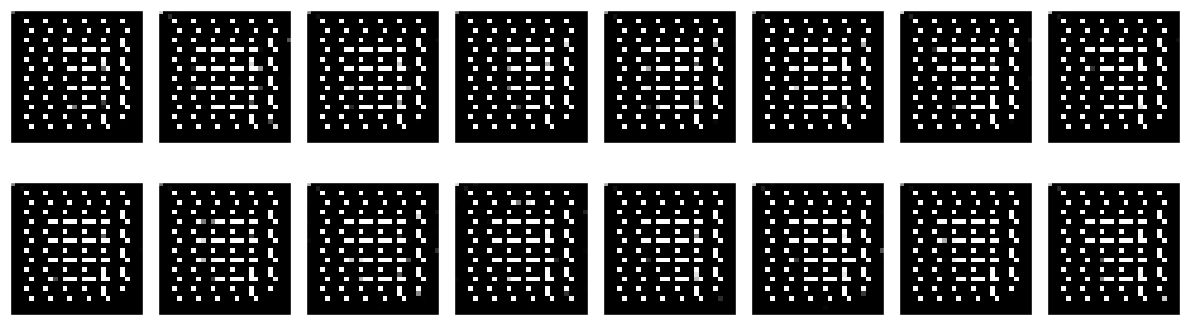

In [5]:
show_generated_images(10)